In [1]:
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import pandas as pd
import keras
import seaborn as sb
import zipfile
from PIL import Image
import PIL
import copy
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, Adagrad, SGD

sb.set()

Using TensorFlow backend.


# Data reading

In [2]:
batch_size = 128
num_classes = 2
epochs = 60
LABELS = ['Cat', 'Dog']
image_size = [50, 50]
input_shape = (50, 50, 2)

In [3]:
class DataReader:
    def __init__(self):
        self.zip_name = "dataset/animals.zip"
        self.train_path = "annotations/annotations/trainval.txt"
        self.test_path = "annotations/annotations/test.txt"
        self.columns = ['file', 'class', 'species', 'breed']

    def read_labels_data(self):
        with zipfile.ZipFile(self.zip_name, 'r') as zip: 
            train_labels_file = zip.extract(self.train_path)
            test_labels_file = zip.extract(self.test_path)
        train_labels = pd.read_csv(train_labels_file, sep=" ", header=None)
        train_labels.columns = self.columns
        test_labels = pd.read_csv(test_labels_file, sep=" ", header=None)
        test_labels.columns = self.columns
        self.return_status(train_labels, test_labels, "Labels")
        return train_labels, test_labels

    def read_image_paths(self, train_y, test_y):
        training_images_paths = []
        testing_images_paths = []
        with zipfile.ZipFile(self.zip_name, 'r') as zip: 
            for i, row in train_y.iterrows():
                name = row['file'] + ".jpg"
                file = zip.extract("images/images/" + name)
                training_images_paths.append(file)
                if not file:
                    print("Incorrect file: " + name)
            for i, row in test_y.iterrows():
                name = row['file'] + ".jpg"
                file = zip.extract("images/images/" + name)
                if not file:
                    print("Incorrect file: " + name)
                testing_images_paths.append(file)
        self.return_status(training_images_paths, testing_images_paths, "Paths")
        return training_images_paths, testing_images_paths
    
    def read_images_from_paths(self, training_paths, testing_paths):
        training_images = []
        testing_images = []
        for file in training_paths:
            image = copy.deepcopy(Image.open(file))
            training_images.append(image)
        for file in testing_paths:
            image = copy.deepcopy(Image.open(file))
            testing_images.append(image)
        self.return_status(training_images, testing_images, "Images")
        return training_images, testing_images
    
    def return_status(self, list1, list2, name):
        if len(list1) == 0 or len(list2) == 0:
            print(name + " list is empty.")
        else:
            print(name + " OK")
    
    def data_reader(self):    
        train_y, test_y = self.read_labels_data()
        training_images_paths, testing_images_paths = self.read_image_paths(train_y, test_y)
        training_images, testing_images = self.read_images_from_paths(training_images_paths, testing_images_paths)
        return training_images, train_y, testing_images, test_y

In [4]:
reader = DataReader()
training_images, training_labels, testing_images, testing_labels = reader.data_reader()

Labels OK
Paths OK
Images OK


In [5]:
class ImageHandler:
    def __init__(self):
        self.figsize = (10, 10)
        
    def show_random_picture(self, image_list):
        fig = plt.figure(figsize=self.figsize)
        plt.rcParams["axes.grid"] = False
        rand = random.randint(0, len(image_list)-1)
        plt.imshow(image_list[rand])
        plt.title("There you go, here is a cute picture.")
        plt.show()
        
    def resize_images(self, imgs_list):
        imgs_resized = []
        for img in imgs_list:
            img = img.convert('LA')
            img = img.resize(image_size, PIL.Image.ANTIALIAS)
            imgs_resized.append(img)
        print("Images resized")
        return imgs_resized
    
    def create_x_array(self, imgs_list):
        imgs_array = []
        for img in imgs_list:
            imgs_array.append(np.asarray(img))
        return imgs_array
    
    def dataframe_to_array(self, df):
        new_array = df.iloc[:, 2].values
        new_array = new_array - 1
        new_array = keras.utils.to_categorical(new_array, num_classes)
        return new_array

    def shuffle_data(self, x, y):
        print("Data shuffling... ", end=" ")
        new_indexes = np.random.permutation(len(y))
        x,y = x[new_indexes], y[new_indexes]
        print("Done.")
        return x,y
    
    def read_all_images(self, images, labels):
        images_resized = self.resize_images(images)
        x = self.create_x_array(images_resized)
        x = np.asarray(x)
        y = self.dataframe_to_array(labels)
        x, y = self.shuffle_data(x, y)
        return x, y

## Some example pictures

In [6]:
image_handler = ImageHandler()
train_x, train_y = image_handler.read_all_images(training_images, training_labels)
test_x, test_y = image_handler.read_all_images(testing_images, testing_labels)

Images resized
Data shuffling...  Done.
Images resized
Data shuffling...  Done.


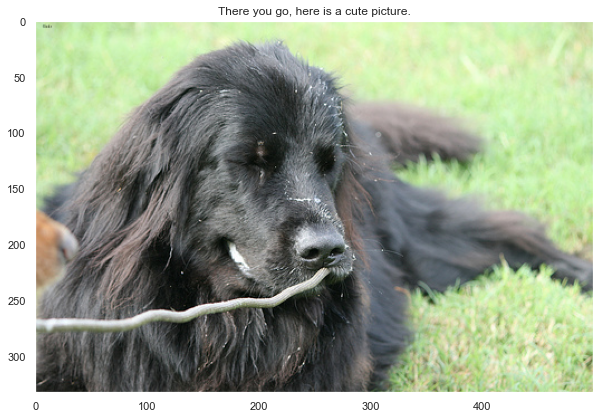

In [7]:
image_handler.show_random_picture(training_images)

# Model and learning
A model class has been implemented to create a more elastic experience in creating models.
Instead of copying each layer and creating multi-line model.add you just add it with methods.

In [8]:
class Model:
    def __init__(self, model, input_shape, num_classes):
        self.input_shape = input_shape
        self.model = model
        self.num_classes = num_classes
        
    def add_input_layer(self, filters, kernel, input_shape, function):
        self.model.add(Conv2D(filters=filters, kernel_size=kernel,activation=function, padding="same", 
                         input_shape=self.input_shape))
        
    def add_single_conv_layer(self, filters, kernel, function):
        self.model.add(Conv2D(filters=filters, kernel_size=kernel,activation=function, padding="same"))
        
    def add_double_conv_layer(self, filters, kernel, function):
        self.model.add(Conv2D(filters=filters, kernel_size=kernel,activation=function, padding="same"))
        self.model.add(Conv2D(filters=filters, kernel_size=kernel,activation=function, padding="same"))       
            
    def add_triple_conv_layer(self, filters, kernel, function):
        self.model.add(Conv2D(filters=filters, kernel_size=kernel,activation=function, padding="same"))
        self.model.add(Conv2D(filters=filters, kernel_size=kernel,activation=function, padding="same"))
        self.model.add(Conv2D(filters=filters, kernel_size=kernel,activation=function, padding="same"))
        
    def add_max_pooling(self, size, strides):
        self.model.add(MaxPooling2D(pool_size=size, strides=strides))
        
    def add_dropout(self, drop):
        self.model.add(Dropout(drop))
        
    def final_layers(self, density, function):
        self.model.add(Flatten())
        self.model.add(Dense(density, activation=function))
        self.model.add(Dense(density, activation=function))
        self.model.add(Dense(num_classes, activation='softmax'))

    def create_model(self): # VGG-16
        self.add_input_layer(64, (3,3), self.input_shape, 'relu')
        self.add_single_conv_layer(64, (3,3), 'relu')
        self.add_max_pooling((2, 2), (2,2))
        
        self.add_triple_conv_layer(256, (3, 3), 'relu')
        self.add_max_pooling((2, 2), (2,2))
        self.add_dropout(0.25)
        
        self.add_triple_conv_layer(512, (3, 3), 'relu')
        self.add_max_pooling((2, 2), (2,2))
        
        self.add_triple_conv_layer(512, (3, 3), 'relu')
        self.add_max_pooling((2, 2), (2,2))
        self.add_dropout(0.4)
        
        self.final_layers(4096, 'relu')
        
        self.model.summary()

In [9]:
model = Sequential()

model_class = Model(model, input_shape, num_classes)
model_class.create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 256)       147712    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)      

In [10]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=5, 
        zoom_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15)

datagen.fit(train_x)

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=30, verbose=1, mode='auto')

history = model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                            epochs=epochs,
                            steps_per_epoch=batch_size,
                            validation_data=(test_x, test_y),
                            verbose=1,
                            callbacks=[checkpoint, early])

c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:931: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3680, 50, 50, 2) (2 channels).
  warnings.warn(
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:120: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3680, 50, 50, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


Epoch 1/60
128/128 [==============================] - 1690s 13s/step - loss: 0.6947 - accuracy: 0.6741 - val_loss: 0.5995 - val_accuracy: 0.6776

Epoch 00001: val_accuracy improved from -inf to 0.67757, saving model to vgg16_1.h5
Epoch 2/60
128/128 [==============================] - 1689s 13s/step - loss: 0.6261 - accuracy: 0.6718 - val_loss: 0.6067 - val_accuracy: 0.6776

Epoch 00002: val_accuracy did not improve from 0.67757
Epoch 3/60
128/128 [==============================] - 1692s 13s/step - loss: 0.5971 - accuracy: 0.6811 - val_loss: 0.5505 - val_accuracy: 0.7010

Epoch 00003: val_accuracy improved from 0.67757 to 0.70101, saving model to vgg16_1.h5
Epoch 4/60
128/128 [==============================] - 1689s 13s/step - loss: 0.5613 - accuracy: 0.7030 - val_loss: 0.5463 - val_accuracy: 0.7255

Epoch 00004: val_accuracy improved from 0.70101 to 0.72554, saving model to vgg16_1.h5
Epoch 5/60
128/128 [==============================] - 1687s 13s/step - loss: 0.5352 - accuracy: 0.7261 

128/128 [==============================] - 1665s 13s/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.8749 - val_accuracy: 0.8337

Epoch 00039: val_accuracy did not improve from 0.84546
Epoch 40/60
128/128 [==============================] - 1665s 13s/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.8351 - val_accuracy: 0.8460

Epoch 00040: val_accuracy improved from 0.84546 to 0.84601, saving model to vgg16_1.h5
Epoch 41/60
128/128 [==============================] - 1655s 13s/step - loss: 0.0197 - accuracy: 0.9933 - val_loss: 0.7517 - val_accuracy: 0.8422

Epoch 00041: val_accuracy did not improve from 0.84601
Epoch 42/60
128/128 [==============================] - 1655s 13s/step - loss: 0.0197 - accuracy: 0.9935 - val_loss: 0.8650 - val_accuracy: 0.8365

Epoch 00042: val_accuracy did not improve from 0.84601
Epoch 43/60
128/128 [==============================] - 1659s 13s/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 1.0274 - val_accuracy: 0.8318

Epoch 00043: val_accuracy

Test loss: 0.8286442066545089
Test accuracy: 0.8381029963493347


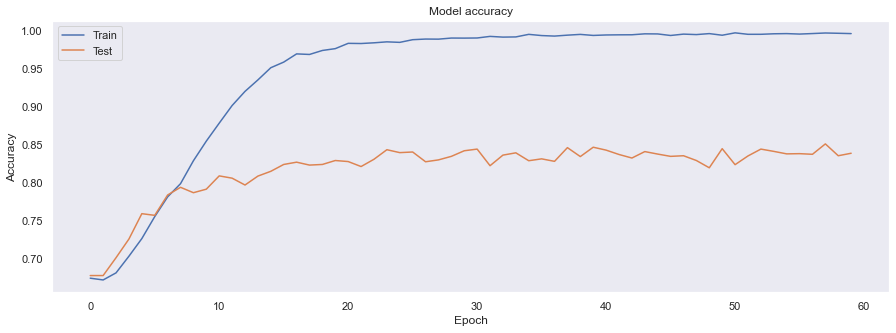

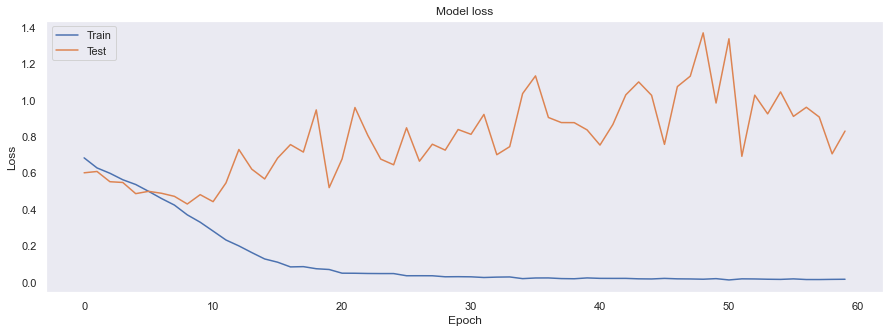

In [11]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 

plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc ='upper left')
plt.show()

In [12]:
LABELS = ['Cat', 'Dog']
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sb.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.invert_yaxis()
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

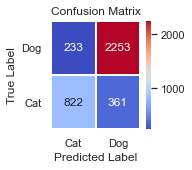

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1183
           1       0.86      0.91      0.88      2486

    accuracy                           0.84      3669
   macro avg       0.82      0.80      0.81      3669
weighted avg       0.84      0.84      0.84      3669



In [13]:
y_pred_test = model.predict(test_x)

max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(test_y, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test, num_classes)

print(classification_report(max_y_test, max_y_pred_test))